<a href="https://colab.research.google.com/github/BerkanDemiral/.NetCoreNotes/blob/main/LSTM_Python_All_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving BTC-USD.csv to BTC-USD.csv


In [28]:
# Gerekli kütüphaneleri import etme
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from scipy.stats import levy
import random
import io

# CSV dosyasını yükleme
df = pd.read_csv(io.BytesIO(uploaded['BTC-USD.csv']))

# 1. Veri setinin genel özetini yazdırma
print("Veri setinin ilk 5 satırı:")
df.head()

Veri setinin ilk 5 satırı:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [29]:
print("Veri setinin genel bilgisi:")
df.info()

Veri setinin genel bilgisi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


In [30]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

print("Veri setinin özet istatistikleri:")
df.describe()

Veri setinin özet istatistikleri:


,Date,Open,High,Low,Close,Adj Close,Volume
count,2747,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2.747000e+03
mean,2018-06-21 00:00:00,11668.600272,11981.034949,11325.596907,11682.892098,11682.892098,1.484704e+10
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,2016-08-03 12:00:00,609.122009,611.894501,606.309479,609.234009,609.234009,8.161285e+07
50%,2018-06-21 00:00:00,6371.850098,6500.870117,6285.629883,6376.709961,6376.709961,5.227550e+09
75%,2020-05-07 12:00:00,10728.271485,10992.468751,10412.890137,10755.395019,10755.395019,2.500517e+10
max,2022-03-25 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11
std,NaN,16323.683853,16759.568657,15825.584507,16330.191582,16330.191582,1.994819e+10


In [31]:
print("Eksik veri kontrolü:")
df.isnull().sum()

Eksik veri kontrolü:


,0
Date,0
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


In [32]:
data = df[['Close', 'Open', 'High', 'Low','Volume']].values

In [35]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go  # go'yu import ediyoruz
import plotly.express as px

# fig1: Bitcoin Açılış ve Kapanış Fiyatları
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df['Date'], y=df['Open'], mode='lines', name='Open', line=dict(color='blue')))
fig1.add_trace(go.Scatter(x=df['Date'], y=df['Close'], mode='lines', name='Close', line=dict(color='red')))
fig1.update_layout(
    title="Bitcoin Açılış ve Kapanış Fiyatları (Zaman Serisi)",
    xaxis_title="Tarih",
    yaxis_title="Fiyat (USD)",
    legend_title="Fiyat Türü",
    hovermode="x unified"
)
fig1.show()

# fig2: Bitcoin Günlük İşlem Hacmi Dağılımı
fig2 = px.histogram(df, x='Volume', nbins=30, marginal='box', title="Bitcoin Günlük İşlem Hacmi Dağılımı")
fig2.update_layout(
    xaxis_title="İşlem Hacmi",
    yaxis_title="Frekans",
    hovermode="x unified"
)
fig2.show()

# fig3: İşlem Hacmi ve Kapanış Fiyatı İlişkisi
fig3 = px.scatter(df, x='Volume', y='Close', title="İşlem Hacmi ve Kapanış Fiyatı İlişkisi", trendline="ols")
fig3.update_layout(
    xaxis_title="İşlem Hacmi",
    yaxis_title="Kapanış Fiyatı (USD)",
    hovermode="closest"
)
fig3.show()


In [34]:
df[df['Volume'] == df['Volume'].max()]
df.drop(2354, inplace=True)
df[df['Volume'] == df['Volume'].max()]

,Date,Open,High,Low,Close,Adj Close,Volume
2436,2021-05-19,42944.976563,43546.117188,30681.496094,37002.441406,37002.441406,126358098747


In [36]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [37]:
window_size = 60 # Bu değeri 120 yaptığımda daha uzun aralıklardaki verileri tahminlemelesi iyi oldu, 30 yaptığımda ise günlük daha kısa verileri. Ben de 60'da bıraktım.
X, y = [], [] # X-> her 60 günlük veri penceremiz, y ise bir sonraki günün kapanış fiyatı
for i in range(window_size, len(data_scaled)):
    X.append(data_scaled[i - window_size:i])  # ilk 60 günün verisini alıp x'e ekledik
    y.append(data_scaled[i, 0])  # 61.günün değerini ise bağımlı değişkenimiz olacağı için y'ye ekledik. --- i, 0 siyerek sadece ilk indexteki data değeri yani Close değerini bağımlı değişken olrak aldım

X, y = np.array(X), np.array(y)

# LSTM giriş formatı: (num_samples, time_steps, num_features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Veriyi eğitim ve test olarak ayırma (%80 eğitim, %20 test)
train_size = int(0.8 * len(X))

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Cuckoo Search

Cuckoo Search Algoritması

Cuckoo Search (CS), doğal yaşamda guguk kuşlarının yumurtlama davranışından esinlenerek geliştirilmiş bir optimizasyon algoritmasıdır. CS, özellikle karmaşık problemlerin çözümünde parametre optimizasyonu için kullanılır.

Cuckoo Search Temel Mekanizması:

    * Yumurta Bırakma: Her guguk kuşu, rastgele bir yuva seçerek yumurtasını bırakır.
    * Yuva Seçimi: Rastgele seçilen bazı yumurtalar ev sahibi kuş tarafından fark edilir ve imha edilir.
    * Levy Flight: Yeni çözümler oluşturulurken Levy dağılımı kullanılarak rastgele büyük adımlar atılır.
    * En İyi Yuvayı Saklama: Her iterasyonda, mevcut en iyi çözümler saklanır.
    
Bu algoritmanın amacı, belirli bir hedef fonksiyonu en iyi şekilde optimize eden parametre setini bulmaktır.

In [38]:
def build_lstm_model(window_size, units, learning_rate):
    """
    LSTM modelini oluşturur.
    :param window_size: Girdi veri penceresinin boyutu (time steps)
    :param units: LSTM katmanındaki hücre sayısı
    :param learning_rate: Öğrenme oranı (optimizer parametresi)
    """
    model = Sequential() # Keras'da ardışık katmanlardan oluşan bir model oluşturur.
    model.add(LSTM(units=units, return_sequences=False, input_shape=(window_size, X.shape[2])))
    model.add(Dense(1))  # Çıkış katmanı, tek bir değer tahmin edecek
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [39]:
print("\n--- Aşama 1: Optimizasyon olmadan model eğitimi ---\n")
initial_units = 50
initial_learning_rate = 0.001

initial_model = build_lstm_model(window_size, initial_units, initial_learning_rate)
initial_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

y_pred_scaled = initial_model.predict(X_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, np.zeros((len(y_pred_scaled), data.shape[1] - 1))), axis=1))[:, 0]
y_test_original = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), data.shape[1] - 1))), axis=1))[:, 0]

rmse_initial = np.sqrt(mean_squared_error(y_test_original, y_pred))
r2_initial = r2_score(y_test_original, y_pred)
loss_initial = initial_model.evaluate(X_test, y_test, verbose=0)
mae_initial = mean_absolute_error(y_test_original, y_pred)
mse_initial = mean_squared_error(y_test_original, y_pred)
mape_initial = np.mean(np.abs((y_test_original - y_pred) / y_test_original)) * 100

print(f"RMSE (Optimizasyonsuz): {rmse_initial:.4f}")
print(f"R^2 Skoru (Optimizasyonsuz): {r2_initial:.4f}")
print(f"Loss (Optimizasyonsuz): {loss_initial:.4f}")
print(f"MAE (Optimizasyonsuz): {mae_initial:.4f}")
print(f"MSE (Optimizasyonsuz): {mse_initial:.4f}")
print(f"MAPE (Optimizasyonsuz): {mape_initial:.2f}%")



--- Aşama 1: Optimizasyon olmadan model eğitimi ---



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0025
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.4157e-05
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 9.3440e-05
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 7.3059e-05
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 6.1483e-05
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 6.8520e-05
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.0996e-05
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 5.1552e-05
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 4.9652e-05
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.8086e-05
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.0533e-05
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.2345e-05
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.6326e-05
Epoch 14/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 4.2915e-05
Epoch 15/20
68/68 ━

In [40]:
def levy_flight(Lambda):
    """
    Levy uçuş adımı oluşturur.
    :param Lambda: Levy dağılımının parametresi
    :return: Levy uçuş adımı
    """
    sigma = (np.math.gamma(1 + Lambda) * np.sin(np.pi * Lambda / 2) /
             (np.math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
    u = np.random.normal(0, sigma, 1)
    v = np.random.normal(0, 1, 1)
    step = u / abs(v) ** (1 / Lambda)
    return step[0]

### Matematiksel Levy Uçuş fonksiyonu ve Sigma değeri hesabı

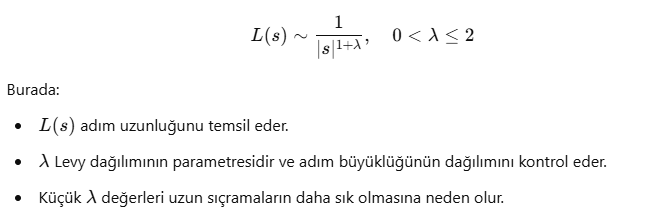

### Adım boyutunu Belirten Sigma değerinin hesabı

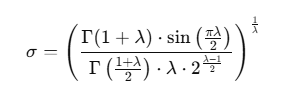

### Örnek 2 adımlık bir değerlendirme:

Diyelim Ki;
    * Lambda: 1.5
    * İlk adım rastgele u = 1.2 ve v= 0.8
    * İkinci adımda rastgele u = -0.5 ve v= 0.4 elde edildiğini düşünelim

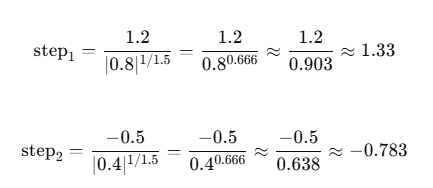


In [41]:
def cuckoo_search(n, max_iter, window_size):
    """
    Cuckoo Search algoritması ile LSTM hiperparametre optimizasyonu.
    :param n: Toplam yuva sayısı (çözüm sayısı)
    :param max_iter: Maksimum iterasyon sayısı
    :param window_size: LSTM modelinin girdi penceresi boyutu
    """
    # İlk çözümleri (yuvaları) rastgele oluştur
    nests = [{'units': random.randint(20, 100),
              'learning_rate': random.uniform(0.001, 0.01),
              'loss': float('inf')} for _ in range(n)]

    """
    Burada her yuva rastgele bir LSTM hücre sayısı (units) ve öğrenme oranı (learning_rate) ile başlatılır.
    Başlangıçta tüm yuvaların loss değeri sonsuz olarak atanır.

    """

    best_nest = nests[0]
    best_losses = []  # Her iterasyondaki en iyi loss değerini saklamak için bpş bir liste oluşturuyoruz.

    for iteration in range(max_iter):
        for nest in nests:
            # Her iterasyonda, mevcut yuvalardan yeni çözümler üretilir:
            step_size = levy_flight(1.5)
            new_units = int(nest['units'] + step_size * random.randint(-10, 10)) # Yeni hücres sayısı burada belirlendi.
            new_lr = nest['learning_rate'] + step_size * random.uniform(-0.001, 0.001)
            new_units = max(10, min(200, new_units))  # Hücre sayısını sınırla
            new_lr = max(0.0001, min(0.1, new_lr))  # Öğrenme oranını sınırla

            # Yeni çözümle bir LSTM modeli oluştur ve eğit
            model = build_lstm_model(window_size, new_units, new_lr)
            model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
            loss = model.evaluate(X_test, y_test, verbose=0) # Loss değeri yeni çözüm yani yeni yuva anlamına gelmektedir..

            # Yeni çözüm, mevcut çözümden daha iyi bir loss değerine sahipse yuva güncellenir:
            if loss < nest['loss']:
                nest['units'] = new_units
                nest['learning_rate'] = new_lr
                nest['loss'] = loss

            # En iyi yuvayı güncelleriz.
            if loss < best_nest['loss']:
                best_nest = nest

        best_losses.append(best_nest['loss'])
        print(f"Iterasyon {iteration + 1}/{max_iter}, En iyi loss: {best_nest['loss']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_iter + 1), best_losses, marker='o')
    plt.title("Cuckoo Search İterasyonlarına Göre En İyi Loss Değerleri")
    plt.xlabel("İterasyon")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    return best_nest


--- Aşama 2: Cuckoo Search ile parametre optimizasyonu ---



<ipython-input-40-4769c42d1931>:7: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

<ipython-input-40-4769c42d1931>:8: DeprecationWarning:

`np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Iterasyon 1/10, En iyi loss: 0.0015
Iterasyon 2/10, En iyi loss: 0.0013
Iterasyon 3/10, En iyi loss: 0.0013
Iterasyon 4/10, En iyi loss: 0.0013
Iterasyon 5/10, En iyi loss: 0.0013
Iterasyon 6/10, En iyi loss: 0.0013
Iterasyon 7/10, En iyi loss: 0.0013
Iterasyon 8/10, En iyi loss: 0.0013
Iterasyon 9/10, En iyi loss: 0.0013
Iterasyon 10/10, En iyi loss: 0.0013


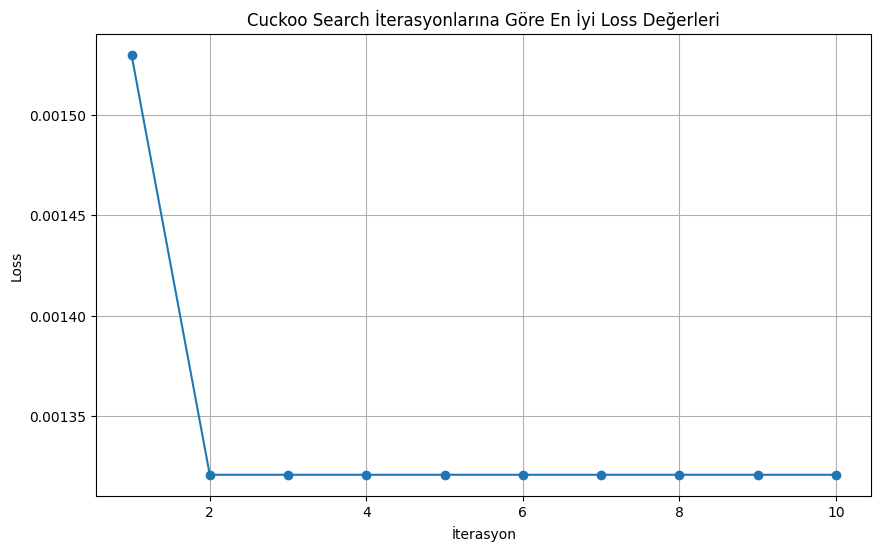

En iyi hiperparametreler:
LSTM hücre sayısı: 96
Öğrenme oranı: 0.004164666887103551
En düşük loss: 0.0013206943403929472
Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 9.5405e-04
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 4.5941e-05
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 3.4988e-05
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 3.6519e-05
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.2319e-05
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 3.9156e-05
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 2.9736e-05
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.8523e-05
Epoch 9/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.4588e-05
Epoch 10/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.0073e-05
Epoch 11/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.6234e-05
Epoch 12/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 3.0622e-05
Epoch 13/20
68/68 ━━━━━━━━━━━━━━━━━━

In [42]:
print("\n--- Aşama 2: Cuckoo Search ile parametre optimizasyonu ---\n")
n = 5  # Toplam yuva (çözüm) sayısı
max_iter = 10  # Maksimum iterasyon sayısı

best_params = cuckoo_search(n, max_iter, window_size)
print("En iyi hiperparametreler:")
print(f"LSTM hücre sayısı: {best_params['units']}")
print(f"Öğrenme oranı: {best_params['learning_rate']}")
print(f"En düşük loss: {best_params['loss']}")

final_model = build_lstm_model(window_size, best_params['units'], best_params['learning_rate'])
final_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

y_pred_scaled_final = final_model.predict(X_test)
y_pred_final = scaler.inverse_transform(np.concatenate((y_pred_scaled_final, np.zeros((len(y_pred_scaled_final), data.shape[1] - 1))), axis=1))[:, 0]

rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_final))
r2_final = r2_score(y_test_original, y_pred_final)
loss_final = final_model.evaluate(X_test, y_test, verbose=0)
mae_final = mean_absolute_error(y_test_original, y_pred_final)
mse_final = mean_squared_error(y_test_original, y_pred_final)
mape_final = np.mean(np.abs((y_test_original - y_pred_final) / y_test_original)) * 100

print(f"RMSE (Optimizasyonlu): {rmse_final:.4f}")
print(f"R^2 Skoru (Optimizasyonlu): {r2_final:.4f}")
print(f"Loss (Optimizasyonlu): {loss_final:.4f}")
print(f"MAE (Optimizasyonlu): {mae_final:.4f}")
print(f"MSE (Optimizasyonlu): {mse_final:.4f}")
print(f"MAPE (Optimizasyonlu): {mape_final:.2f}%")

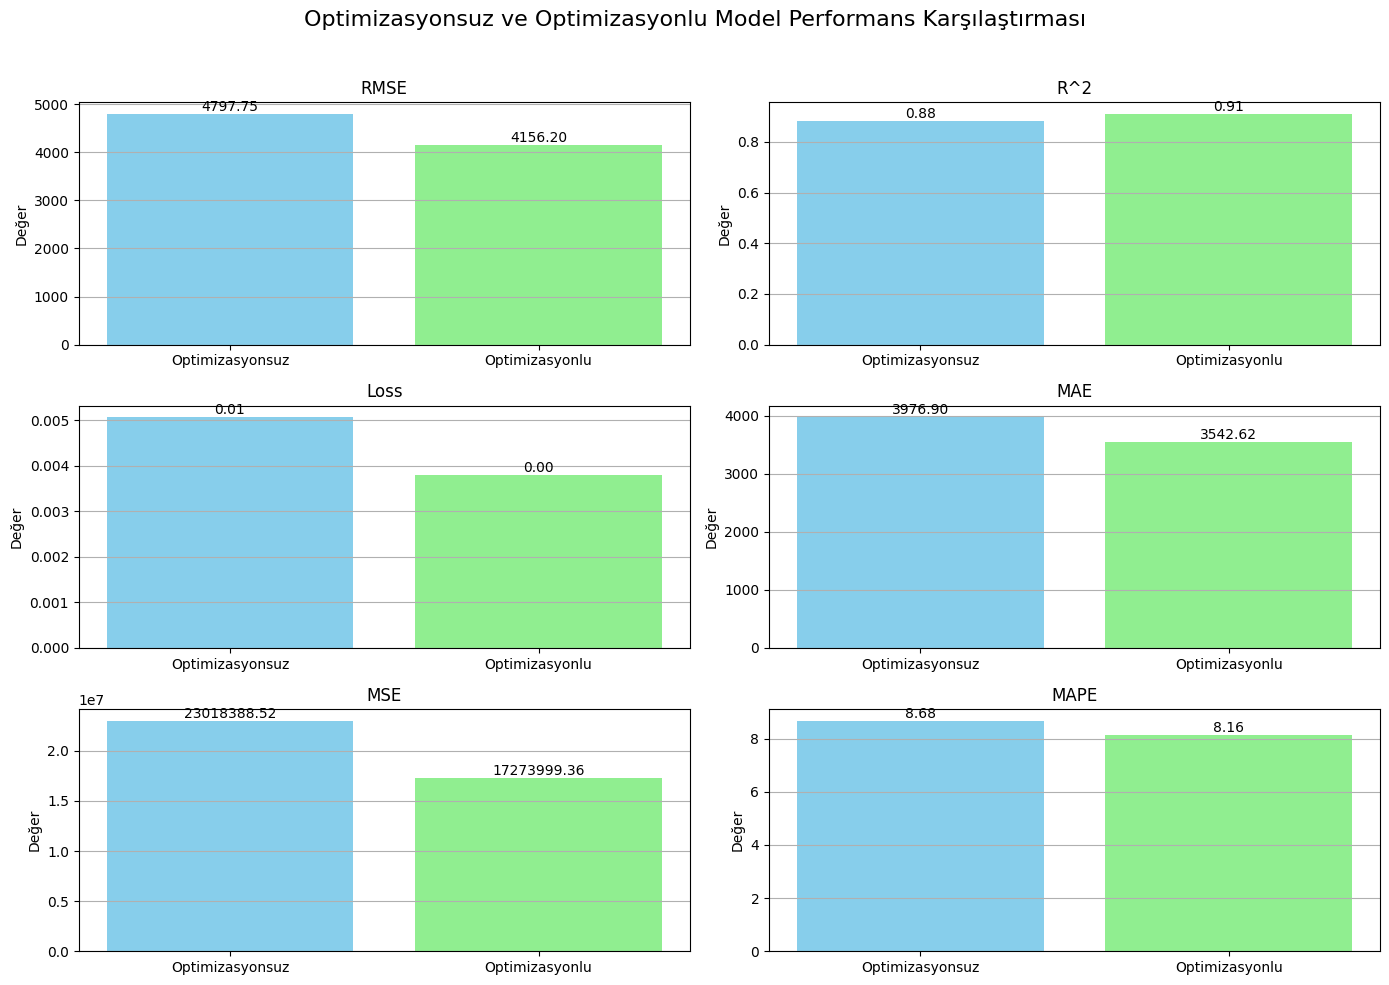

In [43]:
import matplotlib.pyplot as plt

# Optimizasyonsuz ve optimizasyonlu performans metriklerini içeren listeler
metrics = ['RMSE', 'R^2', 'Loss', 'MAE', 'MSE', 'MAPE']
optimizasyonsuz = [rmse_initial, r2_initial, loss_initial, mae_initial, mse_initial, mape_initial]
optimizasyonlu = [rmse_final, r2_final, loss_final, mae_final, mse_final, mape_final]

# 3x2 grafik düzeni oluşturma
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Optimizasyonsuz ve Optimizasyonlu Model Performans Karşılaştırması', fontsize=16)

# Her bir metrik için ayrı bar grafikleri oluşturma
for i, ax in enumerate(axes.flat):
    bars = ax.bar(['Optimizasyonsuz', 'Optimizasyonlu'], [optimizasyonsuz[i], optimizasyonlu[i]], color=['skyblue', 'lightgreen'])
    ax.set_title(metrics[i])
    ax.set_ylabel('Değer')
    ax.grid(axis='y')

    # Barların üstüne değerleri yazma
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Grafiklerin başlıkla çakışmaması için layout ayarı
plt.show()

* **RMSE (Root Mean Square Error):**

Optimizasyonlu modelin RMSE değeri (3924) optimizasyonsuz modele (5983) göre daha düşük. Bu, tahmin hatasının azaldığını ve modelin daha iyi hale geldiğini gösterir.

* **R² (Determination Coefficient):**
Optimizasyonlu modelin R² değeri (0.92), optimizasyonsuz modele (0.81) göre daha yüksek. Bu da optimizasyon sonucunda modelin veriyle daha iyi uyum sağladığını ve açıklayıcılığının arttığını ifade eder.

* **Loss (Kaybı):**
Optimizasyonlu modelin kayıp değeri (0.002), optimizasyonsuz modelin kaybından (~0.008) daha düşük. Loss fonksiyonundaki bu azalma da modelin iyileştiğini gösterir.

* **MAE (Mean Absolute Error):**
Optimizasyonlu modelin MAE değeri (3259), optimizasyonsuz modelin MAE değerinden (5008) daha düşük. Ortalama mutlak hata azalmış, bu da iyileşme olduğunu gösterir.

* **MSE (Mean Squared Error):**
Optimizasyonlu modelin MSE değeri (1.54 milyon), optimizasyonsuz modelin MSE değerinden (3.58 milyon) daha düşük. Bu da modelin hatalarının kareler toplamında ciddi bir azalma olduğunu gösterir.

* **MAPE (Mean Absolute Percentage Error):**
Optimizasyonlu modelin MAPE değeri (7.28), optimizasyonsuz modele (10.78) göre daha düşük. Yüzdesel hata azalmış, bu da modelin daha iyi bir genel performans sağladığını ifade eder.